<a href="https://colab.research.google.com/github/FogtiIstvan/NephroNet/blob/main/NephroNet_ipynb_m%C3%A1solata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: balintg99
Your Kaggle Key: ··········


100%|██████████| 1.52G/1.52G [00:28<00:00, 57.4MB/s]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [5]:
batch_size = 32
img_height = 150
img_width = 150

In [6]:
data_dir = '/content/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
dataset=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                    label_mode = 'categorical', seed=123)


Found 12446 files belonging to 4 classes.


In [7]:
label_to_class_name = dict(zip(range(len(dataset.class_names)), dataset.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [8]:
from tensorflow.keras.utils import to_categorical

num_classes = len(dataset.class_names)
indices = range(num_classes)
one_hot_indices = to_categorical(indices, num_classes=num_classes)

label_to_class_name = {tuple(one_hot_indices[i]): dataset.class_names[i] for i in indices}
label_to_class_name

{(1.0, 0.0, 0.0, 0.0): 'Cyst',
 (0.0, 1.0, 0.0, 0.0): 'Normal',
 (0.0, 0.0, 1.0, 0.0): 'Stone',
 (0.0, 0.0, 0.0, 1.0): 'Tumor'}

In [9]:
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
test_size = int(0.1 * num_samples)
val_size = num_samples - train_size - test_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
val_dataset = dataset.skip(train_size + test_size)

shuffle_buffer_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size)
val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer_size)
test_dataset = test_dataset.shuffle(buffer_size=shuffle_buffer_size)

print(dataset)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [51]:
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

val_size = int(0.9 * val_size)
test_size = num_samples - train_size - val_size

val_dataset = val_dataset.take(val_size)
test_dataset = dataset.skip(train_size + val_size)

train_dataset = train_dataset.shuffle(buffer_size=train_size)
val_dataset = val_dataset.shuffle(buffer_size=val_size)
test_dataset = test_dataset.shuffle(buffer_size=test_size)

print(dataset)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


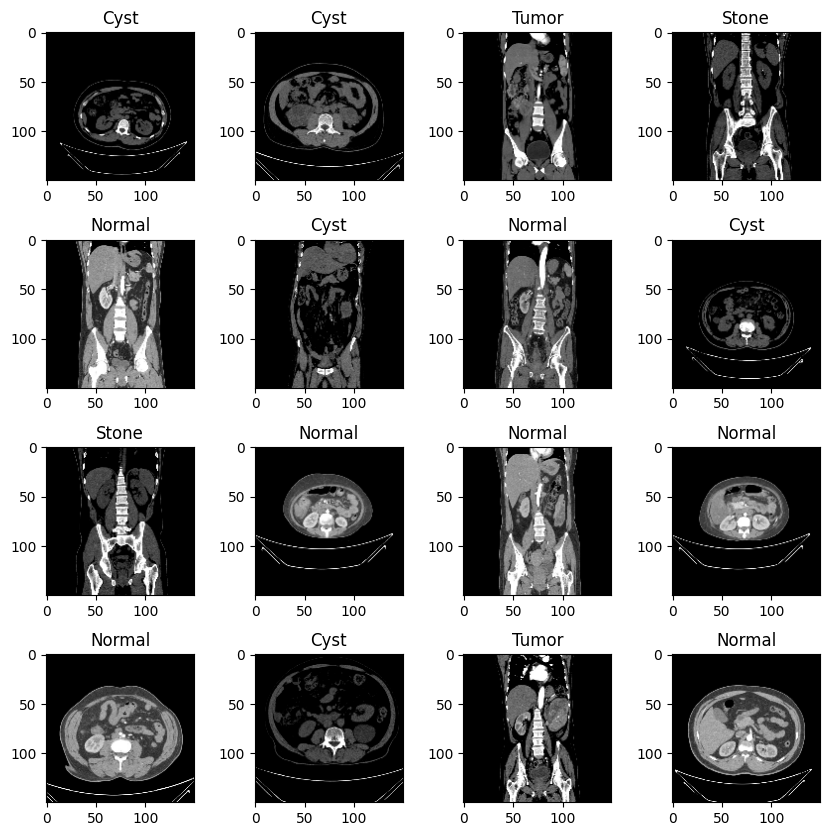

In [10]:
data_iterator = train_dataset.as_numpy_iterator()
batch = data_iterator.next()

# Assuming label_to_class_name has keys as tuples of one-hot encoded values
# Convert one-hot encoded arrays to tuples for dictionary lookup
label_to_class_name = {tuple(key): value for key, value in label_to_class_name.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))

        # Convert the one-hot encoded label array to a tuple
        label_tuple = tuple(batch[1][index])

        # Use the tuple to get the class name from the dictionary
        ax[i, j].set_title(label_to_class_name[label_tuple])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

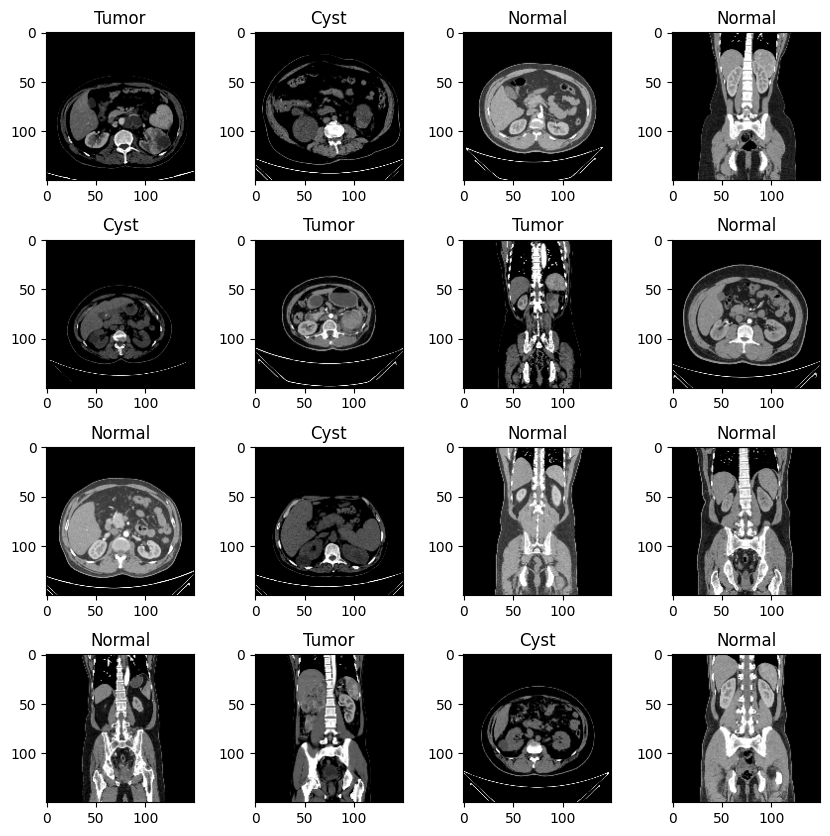

In [11]:
data_iterator = test_dataset.as_numpy_iterator()
batch = data_iterator.next()

# Assuming label_to_class_name has keys as tuples of one-hot encoded values
# Convert one-hot encoded arrays to tuples for dictionary lookup
label_to_class_name = {tuple(key): value for key, value in label_to_class_name.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))

        # Convert the one-hot encoded label array to a tuple
        label_tuple = tuple(batch[1][index])

        # Use the tuple to get the class name from the dictionary
        ax[i, j].set_title(label_to_class_name[label_tuple])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

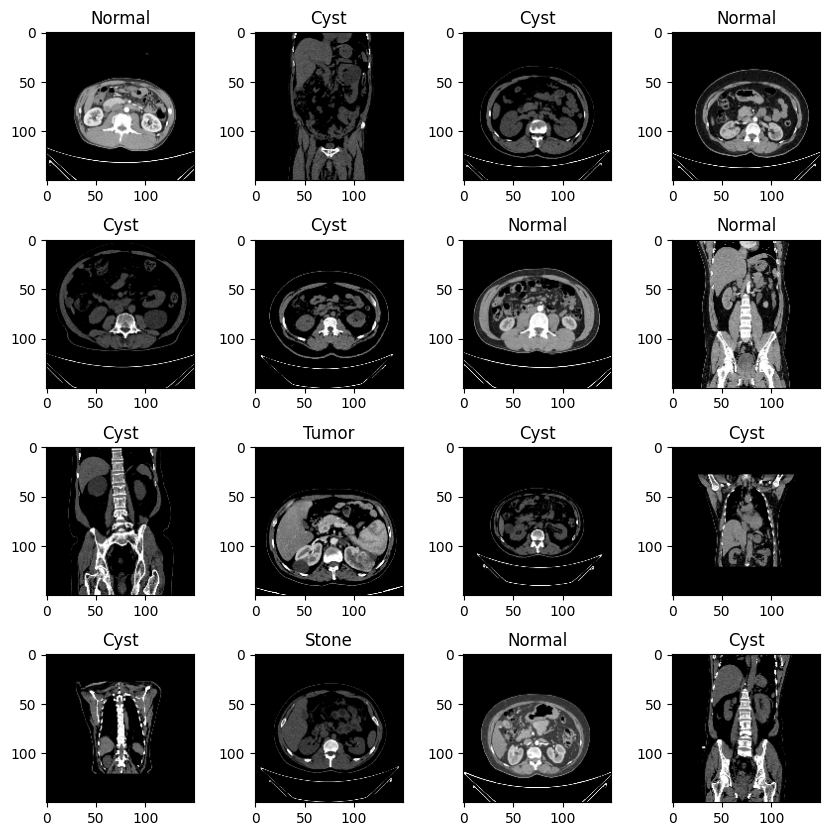

In [54]:
data_iterator = val_dataset.as_numpy_iterator()
batch = data_iterator.next()

# Assuming label_to_class_name has keys as tuples of one-hot encoded values
# Convert one-hot encoded arrays to tuples for dictionary lookup
label_to_class_name = {tuple(key): value for key, value in label_to_class_name.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))

        # Convert the one-hot encoded label array to a tuple
        label_tuple = tuple(batch[1][index])

        # Use the tuple to get the class name from the dictionary
        ax[i, j].set_title(label_to_class_name[label_tuple])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [12]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print("-------------------")
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 4)
-------------------
(32, 150, 150, 3)
(32, 4)


In [13]:
train_dataset=train_dataset.map(lambda x,y:(x/255,y))
val_dataset=val_dataset.map(lambda x,y:(x/255,y))
test_dataset=test_dataset.map(lambda x,y:(x/255,y))

print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next()

# Assuming label_to_class_name has keys as tuples of one-hot encoded values
# Convert one-hot encoded arrays to tuples for dictionary lookup
label_to_class_name = {tuple(key): value for key, value in label_to_class_name.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))

        # Convert the one-hot encoded label array to a tuple
        label_tuple = tuple(batch[1][index])

        # Use the tuple to get the class name from the dictionary
        ax[i, j].set_title(label_to_class_name[label_tuple])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

KeyboardInterrupt: ignored

In [16]:
print(image_batch.shape[1:4])

(150, 150, 3)


In [17]:
model = Sequential()

model.add(Conv2D(32, (5,5), activation = 'relu', input_shape=image_batch.shape[1:4]))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [18]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(train_dataset, epochs=30, batch_size = batch_size,
                            verbose=1, validation_data=test_dataset,
                            callbacks=[early_stopping, checkpointer, tb])

Epoch 1/30
311/311 [==============================] - ETA: 0s - loss: 0.8590 - accuracy: 0.6680
Epoch 1: val_loss improved from inf to 0.49868, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - 89s 171ms/step - loss: 0.8590 - accuracy: 0.6680 - val_loss: 0.4987 - val_accuracy: 0.8084
Epoch 2/30
311/311 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8995
Epoch 2: val_loss improved from 0.49868 to 0.09898, saving model to model.hdf5
311/311 [==============================] - 19s 63ms/step - loss: 0.2759 - accuracy: 0.8995 - val_loss: 0.0990 - val_accuracy: 0.9646
Epoch 3/30
  1/311 [..............................] - ETA: 8s - loss: 0.1018 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9749
Epoch 3: val_loss improved from 0.09898 to 0.01283, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - 23s 73ms/step - loss: 0.0769 - accuracy: 0.9749 - val_loss: 0.0128 - val_accuracy: 0.9959
Epoch 4/30
311/311 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9884
Epoch 4: val_loss did not improve from 0.01283
311/311 [==============================] - 21s 66ms/step - loss: 0.0371 - accuracy: 0.9884 - val_loss: 0.0249 - val_accuracy: 0.9910
Epoch 5/30
310/311 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9932
Epoch 5: val_loss improved from 0.01283 to 0.00621, saving model to model.hdf5
311/311 [==============================] - 17s 55ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0062 - val_accuracy: 0.9984
Epoch 6/30
  1/311 [..............................] - ETA: 9s - loss: 0.1104 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9898
Epoch 6: val_loss did not improve from 0.00621
311/311 [==============================] - 21s 68ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.0078 - val_accuracy: 0.9959
Epoch 7/30
310/311 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9960
Epoch 7: val_loss improved from 0.00621 to 0.00236, saving model to model.hdf5
311/311 [==============================] - 21s 67ms/step - loss: 0.0148 - accuracy: 0.9960 - val_loss: 0.0024 - val_accuracy: 0.9992


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/30
311/311 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9937
Epoch 8: val_loss improved from 0.00236 to 0.00027, saving model to model.hdf5
311/311 [==============================] - 20s 65ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 2.7038e-04 - val_accuracy: 1.0000
Epoch 9/30
  1/311 [..............................] - ETA: 9s - loss: 0.0067 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9904
Epoch 9: val_loss did not improve from 0.00027
311/311 [==============================] - 20s 66ms/step - loss: 0.0330 - accuracy: 0.9904 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 10/30
310/311 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9981
Epoch 10: val_loss improved from 0.00027 to 0.00009, saving model to model.hdf5
311/311 [==============================] - 19s 62ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 8.8913e-05 - val_accuracy: 1.0000
Epoch 11/30
  1/311 [..............................] - ETA: 8s - loss: 0.0056 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/311 [============================>.] - ETA: 0s - loss: 6.0500e-04 - accuracy: 0.9999
Epoch 11: val_loss improved from 0.00009 to 0.00000, saving model to model.hdf5
311/311 [==============================] - 21s 68ms/step - loss: 6.0306e-04 - accuracy: 0.9999 - val_loss: 3.7265e-06 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 12/30
310/311 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9912
Epoch 12: val_loss did not improve from 0.00000
311/311 [==============================] - 20s 64ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0128 - val_accuracy: 0.9934
Epoch 13/30
311/311 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9960
Epoch 13: val_loss did not improve from 0.00000
311/311 [==============================] - 21s 68ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0017 - val_accuracy: 0.9992
Epoch 14/30
311/311 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9969
Epoch 14: val_loss did not improve from 0.00000
311/311 [==============================] - 19s 62ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9967
Epoch 15/30
311/311 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9943
Epoch 15: val_loss did not improve from 0.00000
311/311 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 22/30
310/311 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9966
Epoch 22: val_loss did not improve from 0.00000
311/311 [==============================] - 21s 68ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.1140 - val_accuracy: 0.9704
Epoch 23/30
310/311 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9923
Epoch 23: val_loss did not improve from 0.00000
311/311 [==============================] - 20s 64ms/step - loss: 0.0284 - accuracy: 0.9924 - val_loss: 0.0153 - val_accuracy: 0.9942
Epoch 24/30
310/311 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9942
Epoch 24: val_loss did not improve from 0.00000
311/311 [==============================] - 23s 74ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 3.7837e-04 - val_accuracy: 1.0000
Epoch 25/30
310/311 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9973
Epoch 25: val_loss did not improve from 0.00000
311/311 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 29/30
310/311 [============================>.] - ETA: 0s - loss: 2.4146e-05 - accuracy: 1.0000
Epoch 29: val_loss improved from 0.00000 to 0.00000, saving model to model.hdf5
311/311 [==============================] - 20s 65ms/step - loss: 2.4069e-05 - accuracy: 1.0000 - val_loss: 4.2916e-07 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 30/30
310/311 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9953
Epoch 30: val_loss did not improve from 0.00000
311/311 [==============================] - 20s 65ms/step - loss: 0.0209 - accuracy: 0.9952 - val_loss: 0.0211 - val_accuracy: 0.9926


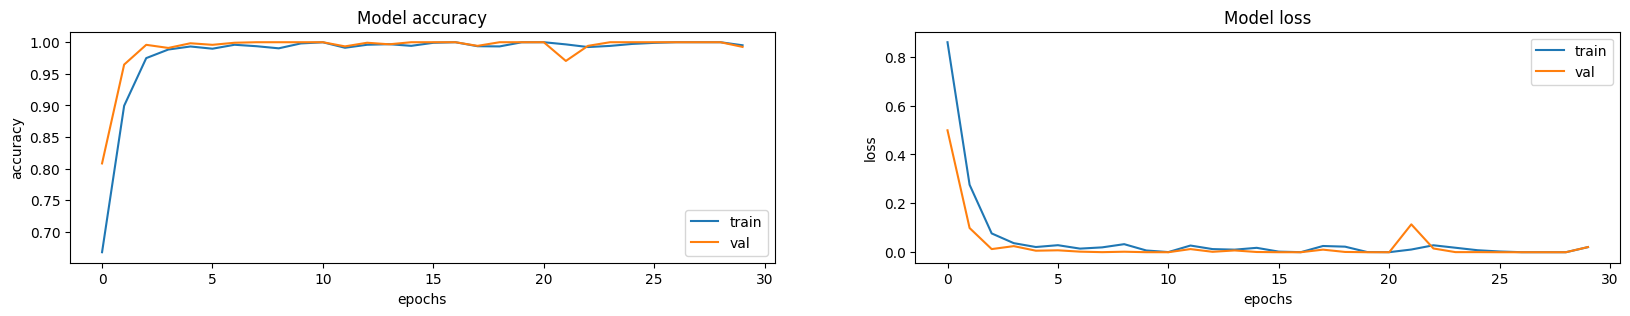

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(network_history.history[met])
    ax[i].plot(network_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

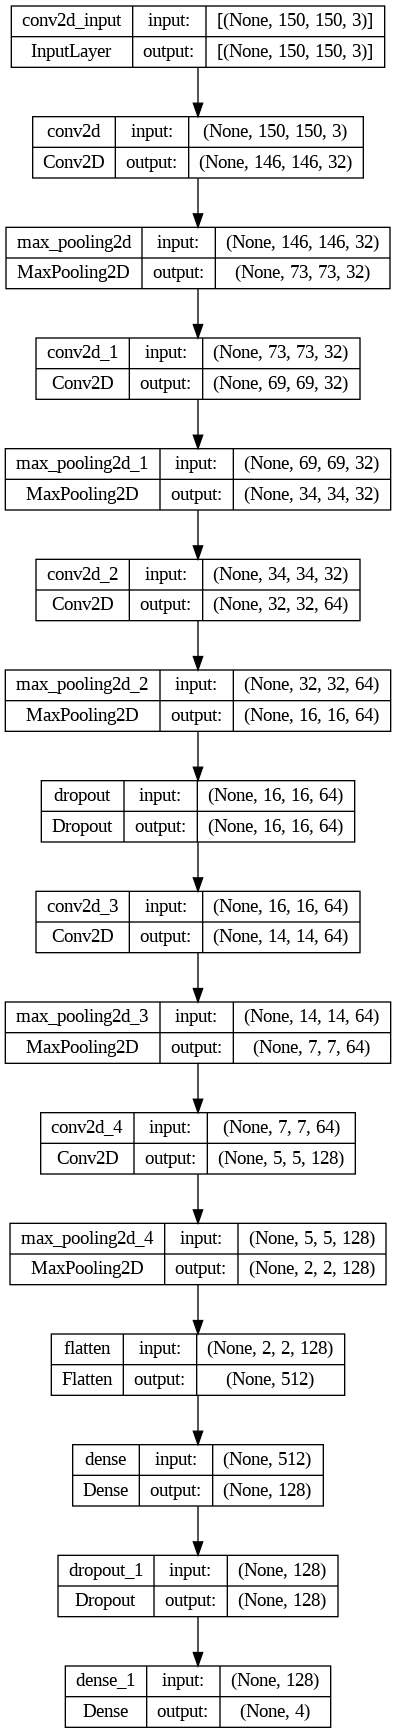

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes = True, show_layer_names = True)

In [22]:
model.evaluate(val_dataset)


40/40 [==============================] - 30s 25ms/step - loss: 0.0149 - accuracy: 0.9945


[0.014864676631987095, 0.9945226907730103]

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

y_pred = model.predict(val_dataset)
y_pred = np.argmax(y_pred,1)

true_labels = []
for _, labels in val_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.argmax(np.array(true_labels), axis=1)

report = classification_report(true_labels, y_pred, target_names=label_to_class_name.values())
print(report)

40/40 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

        Cyst       0.98      1.00      0.99       394
      Normal       1.00      1.00      1.00       517
       Stone       1.00      0.94      0.97       127
       Tumor       1.00      1.00      1.00       240

    accuracy                           0.99      1278
   macro avg       1.00      0.99      0.99      1278
weighted avg       0.99      0.99      0.99      1278



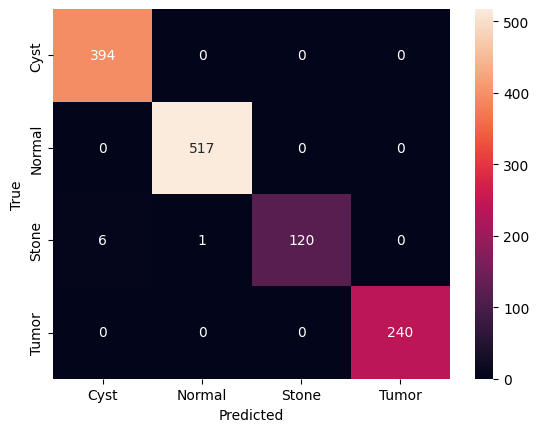

In [24]:
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=label_to_class_name.values(), yticklabels=label_to_class_name.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [25]:
print("test accuracy: %g" %(accuracy_score(true_labels, y_pred)))
print("Precision", precision_score(true_labels, y_pred, average="macro"))
print("Recall", recall_score(true_labels, y_pred, average="macro"))
print("f1_score", f1_score(true_labels, y_pred, average="macro"))
print("\nConfusion matrix: ")
conf=confusion_matrix(true_labels, y_pred)
print(conf)

test accuracy: 0.994523
Precision 0.9957673745173745
Recall 0.9862204724409449
f1_score 0.9907842650976221

Confusion matrix: 
[[394   0   0   0]
 [  0 517   0   0]
 [  6   1 120   0]
 [  0   0   0 240]]
